# Marly Integration with Langgraph
This notebook example shows how Marly can be used together with popular AI agent framework like Langchain to perform tasks. Langchain multi-agent library Langgraph does a good job in orchestrating collaboration among agents. In the below example workflow, two Agents: pdf_processor and chart_generator convert table data from a 10k pdf report into a line chart. Users only need to instruct the agents what table schemas need to be extracted from which pdf file. 

The pdf_generator is using Marly as a tool to perform high quality data extraction based on pdf document and schema.

The resulting graph will be something like below diagram:




![Alt text](./diagram.jpeg)

## Pre-Setup

### Install Dependencies

In [33]:
%%capture --no-stderr
%pip install -U marly langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core PyPDF2

### Setup Openai API Key

In [34]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

## Build Agentic Flow

### Define Agent

In [199]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

### Define Tools

In [200]:
from typing import Annotated
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from dotenv import load_dotenv
import os
import logging
import base64
import zlib
import json

import marly
from marly import Marly

load_dotenv()
client = Marly(
    base_url="http://localhost:8100",
    max_retries=10,
)

PDF_FILE_PATH = "../example_scripts/lacers_reduced.pdf"

# Define schema for Marly, table column name and a breif description of the column
SCHEMA = {
        "Firm": "The name of the firm",
        "Number of Funds": "The number of funds managed by the firm",
        "Commitment": "The commitment amount in millions of dollars",
        "Percent of Total Comm": "The percentage of total commitment",
        "Exposure (FMV + Unfunded)": "The exposure including fair market value and unfunded commitments in millions of dollars",
        "Percent of Total Exposure": "The percentage of total exposure",
        "TVPI": "Total Value to Paid-In multiple",
        "Net IRR": "Net Internal Rate of Return as a percentage"
    }

def read_and_encode_pdf(file_path):
    with open(file_path, "rb") as file:
        pdf_content = base64.b64encode(zlib.compress(file.read())).decode('utf-8')
    logging.debug(f"{file_path} read and encoded")
    return pdf_content

# Define the tool to process the pdf file
@tool
def process_pdf_tool(pdf_file_path: str, schema: str) -> list[dict]:
    """Use this to process the pdf file. """
    pipeline_response_model = None
    try:
        pipeline_response_model = client.pipelines.create(
            api_key=os.environ.get("OPENAI_API_KEY"),
            provider_model_name="gpt-4o",
            provider_type="openai",
            workloads=[
                {
                    "pdf_stream": read_and_encode_pdf(pdf_file_path),
                    "schemas": [schema]
                }
            ]
        )
    except marly.APIConnectionError as e:
        print("The server could not be reached")
        print(e.__cause__)  # an underlying Exception, likely raised within httpx.
    except marly.RateLimitError as e:
        print("A 429 status code was received; we should back off a bit.")
    except marly.APIStatusError as e:
        print("Another non-200-range status code was received")
        print(e.status_code)
        print(e.response)
    
    return client.pipelines.retrieve(pipeline_response_model.task_id).results


repl = PythonREPL()

# Define the tool to execute python code
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

/opt/homebrew/lib/python3.12/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "schema" in "ProcessPdfTool" shadows an attribute in parent "ValidatedFunction.create_model.<locals>.DecoratorBaseModel"
  warnings.warn(
/opt/homebrew/lib/python3.12/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "schema" in "process_pdf_tool" shadows an attribute in parent "BaseModel"
  warnings.warn(


### Define State

In [201]:
import operator
from typing import Annotated, Sequence, TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

In [202]:
import functools

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }


pdf_processor = create_agent(
    llm,
    [process_pdf_tool],
    system_message="You should process the PDF and return the results.",
)
extraction_node = functools.partial(agent_node, agent=pdf_processor, name="pdf_processor")


chart_generator = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_generator, name="chart_generator")

/opt/homebrew/lib/python3.12/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "schema" in "process_pdf_tool" shadows an attribute in parent "BaseModel"
  warnings.warn(


### Define Tool Node

In [203]:
from langgraph.prebuilt import ToolNode

tools = [process_pdf_tool, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic

In [204]:
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        if state["sender"] == "pdf_processor":
            return "continue"
        return "__end__"
    return "continue"

### Define the Graph

In [205]:
workflow = StateGraph(AgentState)

workflow.add_node("pdf_processor", extraction_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "pdf_processor",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "pdf_processor", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "pdf_processor": "pdf_processor",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "pdf_processor")
graph = workflow.compile()

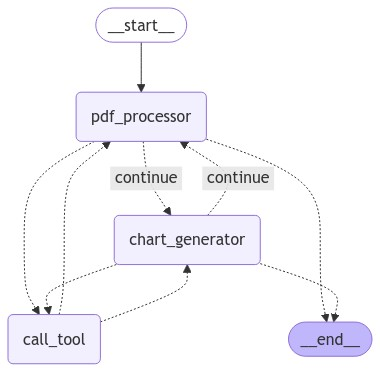

In [206]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'pdf_processor': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DoaZN3Vn3CPi0nPDOBp6MfSu', 'function': {'arguments': '{"pdf_file_path":"../example_scripts/lacers_reduced.pdf","schema":"{\\"Firm\\": \\"The name of the firm\\", \\"Number of Funds\\": \\"The number of funds managed by the firm\\", \\"Commitment\\": \\"The commitment amount in millions of dollars\\", \\"Percent of Total Comm\\": \\"The percentage of total commitment\\", \\"Exposure (FMV + Unfunded)\\": \\"The exposure including fair market value and unfunded commitments in millions of dollars\\", \\"Percent of Total Exposure\\": \\"The percentage of total exposure\\", \\"TVPI\\": \\"Total Value to Paid-In multiple\\", \\"Net IRR\\": \\"Net Internal Rate of Return as a percentage\\"}"}', 'name': 'process_pdf_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 327, 'total_tokens': 474, 'completion_tokens_details': {

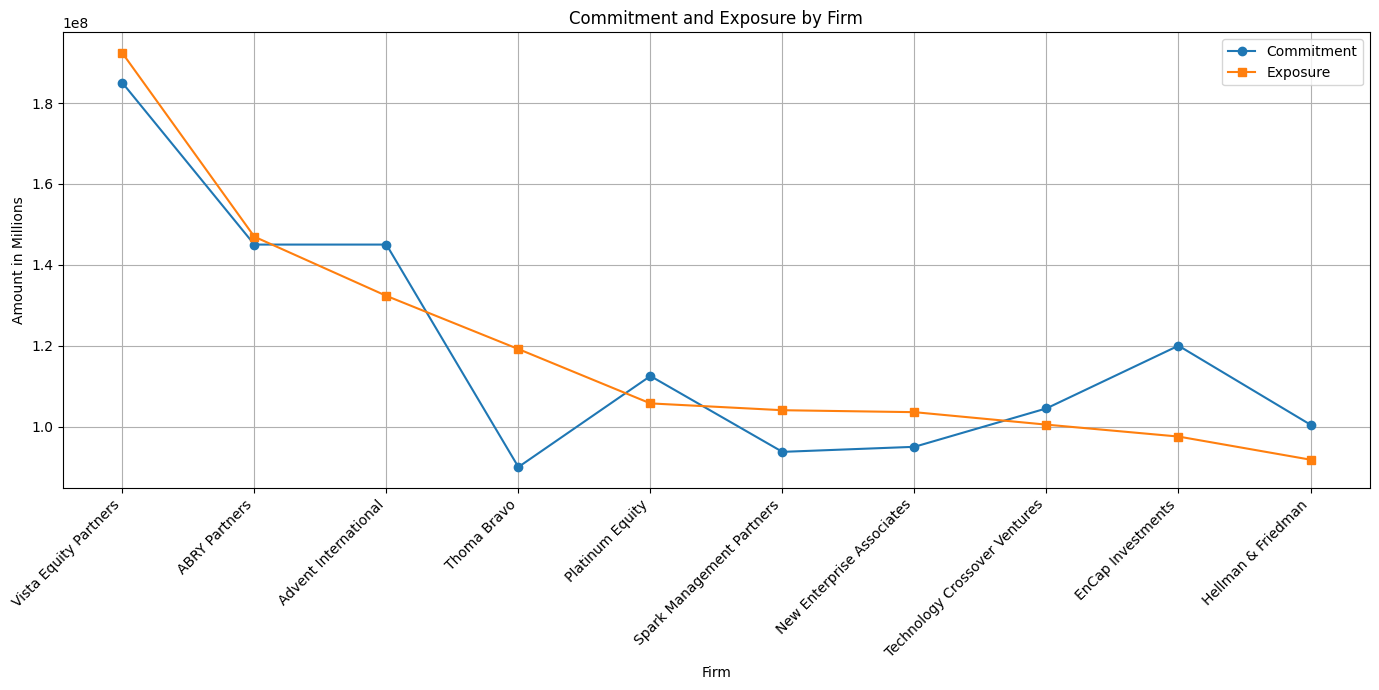

{'chart_generator': {'messages': [AIMessage(content='The data has been successfully extracted from the PDF. Here is the extracted data according to the specified schema:\n\n- **Firm**: \n  - Vista Equity Partners\n  - ABRY Partners\n  - Advent International\n  - Thoma Bravo\n  - Platinum Equity\n  - Spark Management Partners\n  - New Enterprise Associates\n  - Technology Crossover Ventures\n  - EnCap Investments\n  - Hellman & Friedman\n\n- **Number of Funds**: \n  - 7\n  - 6\n  - 5\n  - 5\n  - 4\n  - 6\n  - 4\n  - 5\n  - 4\n  - 5\n\n- **Commitment**: \n  - $185,000,000\n  - $145,000,000\n  - $145,000,000\n  - $90,000,000\n  - $112,500,000\n  - $93,750,000\n  - $95,000,000\n  - $104,500,000\n  - $120,000,000\n  - $100,463,972\n\n- **Percent of Total Comm**: \n  - 3.6%\n  - 2.8%\n  - 2.8%\n  - 1.8%\n  - 2.2%\n  - 1.8%\n  - 1.9%\n  - 2.0%\n  - 2.3%\n  - 2.0%\n\n- **Exposure (FMV + Unfunded)**: \n  - $192,356,158\n  - $146,947,169\n  - $132,320,692\n  - $119,164,173\n  - $105,732,861\n  -

In [207]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"Extract data under the schema {json.dumps(SCHEMA)} from the PDF under the path {PDF_FILE_PATH}," 
                f" then pass the schema and pdf path as inputs to the chart_generator agent to draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")